# for making the figure showing infection of bacteria, archaea, eukaryotes. 
# the specific host was determined using https://www.genome.jp/virushostdb/

In [140]:
import os
import random
import metapredict as meta
import numpy as np
import matplotlib
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve
import protfasta
from scipy.stats import norm, gaussian_kde
from collections import defaultdict
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'
# set fonts
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

# set colors for plots here. Colors are for V1, v2, and v3. Chosen because Ryan can differentiate them.
v1color='#FF9D33'
v2color='#FF6433'
v3color='#CC2D46'
hybridcolor='black'
pLDDT_color='blue'


In [89]:

# read in data.
def read_in_tsv(path_to_tsv):
    per_protein=[]
    total_proteome=[]
    with open(path_to_tsv) as fh:
        lines=fh.read().split('\n')
    fh.close()
    for l in lines[1:]:
        if l != '':
            if len (l.split('\t'))==3:
                vals=l.split('\t')
                per_protein.append(float(vals[1]))
                total_proteome.append(float(vals[2]))
    return {'per_protein':per_protein, 'total_proteome':total_proteome}


archaea_infecting=read_in_tsv('archaeal_infecting_viruses.tsv')
bacteria_infecting=read_in_tsv('bacterial_infecting_viruses.tsv')
eukaryotic_infecting=read_in_tsv('eukaryotic_infecting_viruses.tsv')
human_infecting=read_in_tsv('human_infecting_viruses.tsv')
ecoli_infecting=read_in_tsv('ecoli_infecting_viruses.tsv')
sulfobus_infecting=read_in_tsv('Sulfolobus_islandicus_infecting_viruses.tsv')
metazoa_infecting=read_in_tsv('metazoa_infecting_viruses.tsv')
vertebrate_infecting=read_in_tsv('vertebrate_infecting.tsv')
mammal_infecting=read_in_tsv('mammal_infecting.tsv')
primate_infecting=read_in_tsv('primate_infecting.tsv')

In [146]:
# functions to help with graphing points and spreading them out on the scatterplot.
def generate_uniformly_spaced_points(min_val, max_val, num_points):
    """
    Generates a specified number of uniformly spaced points between a minimum and maximum value.

    Parameters:
    min_val (float): The minimum value.
    max_val (float): The maximum value.
    num_points (int): The number of uniformly spaced points to generate.

    Returns:
    list of floats: The uniformly spaced points.
    """
    if num_points < 2:
        raise ValueError("num_points must be at least 2 to generate a range of points.")
    
    step = (max_val - min_val) / (num_points - 1)
    return [min_val + i * step for i in range(num_points)]
    
def jitter_based_on_density(y_coords, grouping_by=0.01, min_val=0, max_val=0.5, base_jitter=0.25):
    """
    Jitters x positions of data points based on the density of nearby points.

    Parameters:
    y_coords (list of floats): The y coordinates of the data points.

    Returns:
    list of tuples: The data points with jittered x positions.
    """
    # sort the data
    data=sorted(y_coords)
    groups=[]
    center=min_val+((max_val-min_val)/2)
    total_vals=len(y_coords)
    for i in np.arange(min(y_coords)-grouping_by, max(y_coords)+(grouping_by*3), grouping_by):
        i=round(float(i),5)
        totpoints=len([a for a in y_coords if a >=i and a<round(i+grouping_by, 5)])
        if totpoints!=0:
            if totpoints==1:
                groups.extend([center])
            else:
                plus_minus=(totpoints/total_vals)/2
                if totpoints <= 4:
                    curvals=generate_uniformly_spaced_points(center-plus_minus, center+plus_minus, totpoints)
                elif totpoints >4 and totpoints < 10:
                    curvals=generate_uniformly_spaced_points(center-(plus_minus+(base_jitter/2)), center+(plus_minus+(base_jitter/2)), totpoints)
                else:
                    curvals=generate_uniformly_spaced_points(center-(plus_minus+(base_jitter)), center+(plus_minus+(base_jitter)), totpoints)
                random.shuffle(curvals)
                groups.extend(curvals)
    return[data, groups]
        
def generate_scatter_data(y_values, center=0, width_factor=1.0):
    """
    Generates X values that correspond to given Y values for a scatter plot.
    The width of the distribution on the X-axis depends on the number of data points.

    Parameters:
    y_values (list or array): Input Y values.
    center (float): The center value on the X-axis (default: 0).
    width_factor (float): Factor to control how wide the X values are spread (default: 1.0).

    Returns:
    tuple: X and Y values to plot.
    """
    num_points = len(y_values)
    
    # Generate X values spread across a normal distribution based on the number of data points
    x_values = np.linspace(center - width_factor, center + width_factor, num_points)
    
    # Optionally shuffle X values to avoid strict linearity in the plot
    np.random.shuffle(x_values)
    
    return x_values, y_values
    
def generate_density_based_scatter_data(y_values, center=0, base_width=1.0, scale_factor=2.0, abs_range=0.3):
    """
    Generates X values for a scatter plot where denser areas on the Y-axis are spread wider on the X-axis.
    
    Parameters:
    y_values (list or array): Input Y values.
    center (float): The center of the X-axis distribution (default: 0).
    base_width (float): Base width of the X distribution for the sparsest areas (default: 1.0).
    scale_factor (float): Factor to scale the X width based on local density (default: 2.0).
    abs_range (float) : absolute range +/- the center a value can be
    Returns:
    tuple: X and Y values to plot.
    """
    # Calculate the density of Y values using a Gaussian KDE
    kde = gaussian_kde(y_values)
    
    # Evaluate the density for each Y value
    density = kde(y_values)
    
    # Normalize density to [0, 1] range to scale the X-axis width
    density_normalized = (density - density.min()) / (density.max() - density.min())
    
    # Generate X values based on the local density of Y values
    x_spread = base_width + scale_factor * density_normalized
    x_values = np.random.normal(loc=center, scale=x_spread, size=len(y_values))
    
    
    return x_values, y_values


Text(69.70833333333334, 0.5, 'Fraction Disorder')

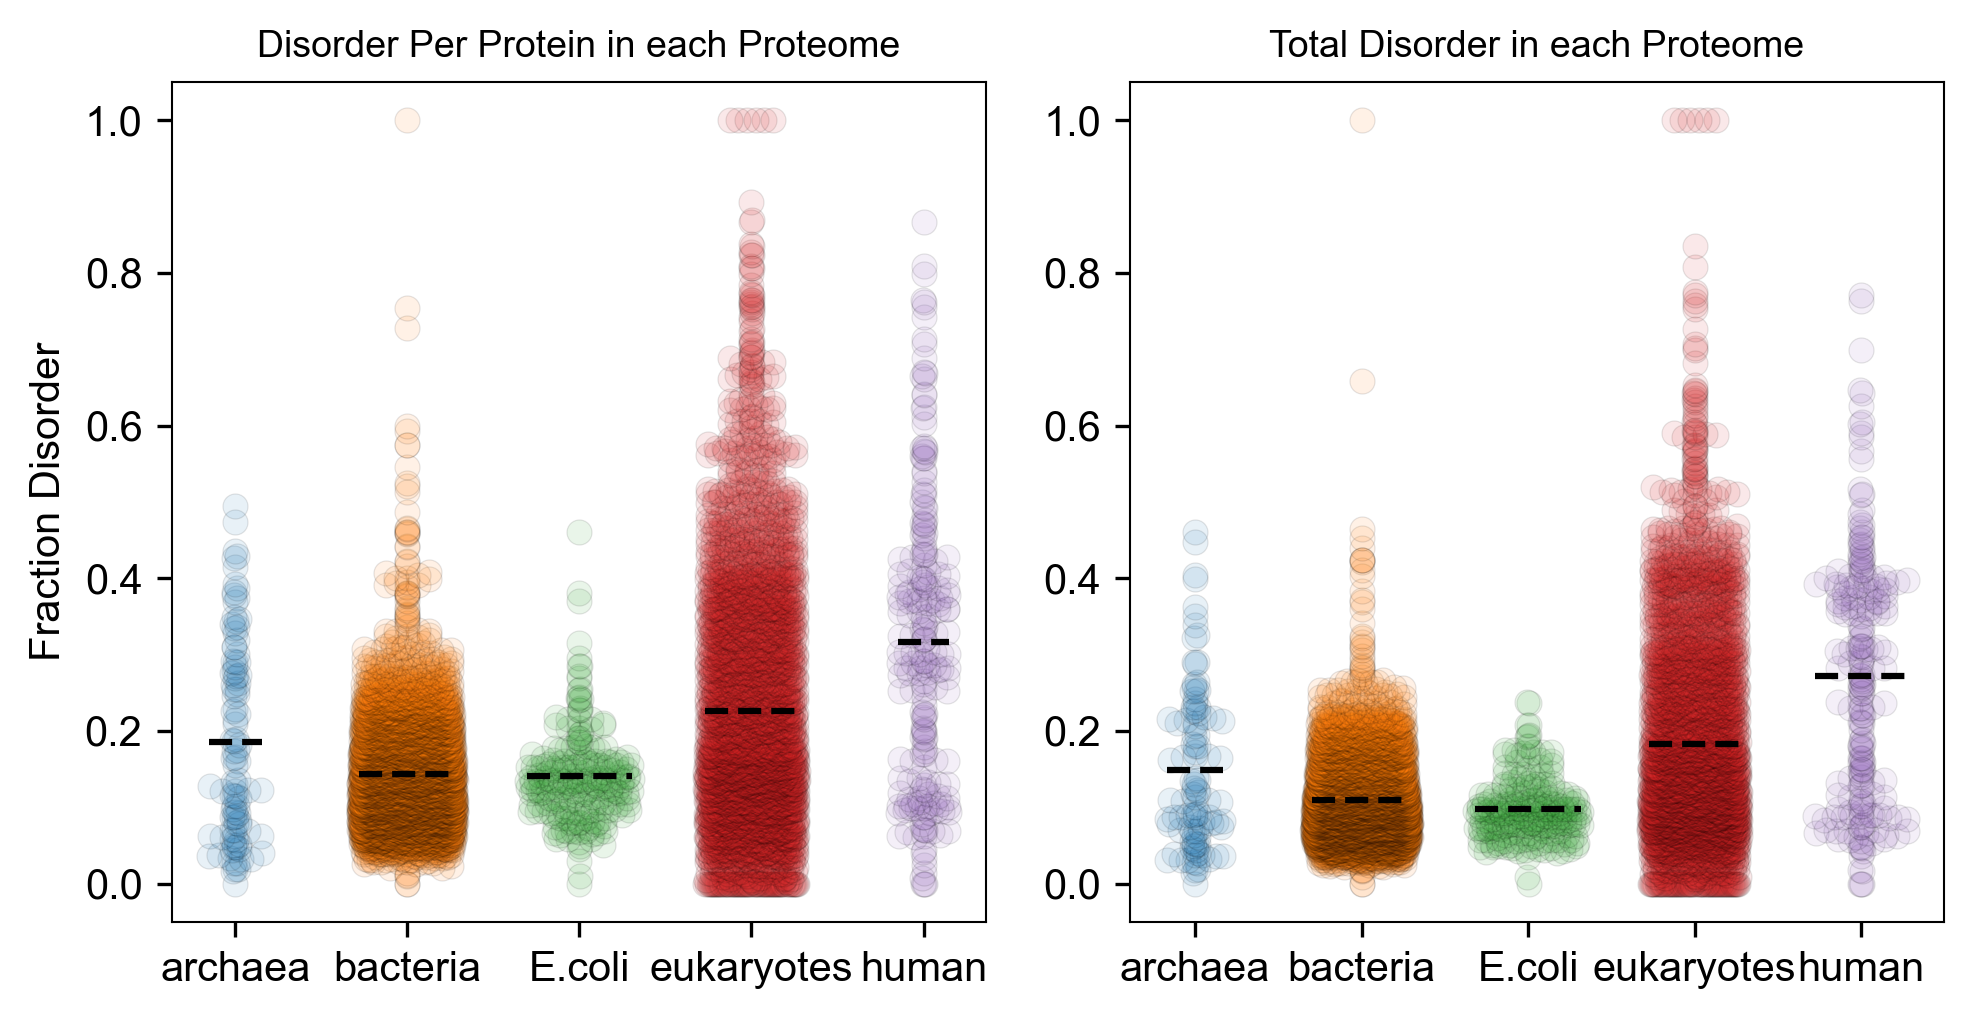

In [117]:
#proteomes={'archaea':archaea_infecting,'S.\nislandicus':sulfobus_infecting, 'bacteria': bacteria_infecting, 'E.coli': ecoli_infecting, 'eukaryotes': eukaryotic_infecting, 'human':human_infecting}
proteomes={'archaea':archaea_infecting, 'bacteria': bacteria_infecting, 'E.coli': ecoli_infecting, 'eukaryotes': eukaryotic_infecting, 'human':human_infecting}
fig, [per_prot, total]=plt.subplots(ncols=2, nrows=1, figsize=(6.5, 3.5), dpi=150, facecolor='w', edgecolor='k')
for n, p in enumerate(proteomes): 
    #plot per protein
    data=jitter_based_on_density(proteomes[p]['per_protein'], min_val=n, max_val=n)
    per_prot.scatter(data[1], data[0], edgecolor='black', linewidth=0.3, alpha=0.1)
    avg=np.mean(data[0])
    per_prot.plot([min(data[1]), max(data[1])], [avg,avg], color='black', linestyle='dashed')
    per_prot.set_title('Disorder Per Protein in each Proteome', fontsize=9)
    # plot total
    data=jitter_based_on_density(proteomes[p]['total_proteome'], min_val=n, max_val=n)
    total.scatter(data[1], data[0], edgecolor='black', linewidth=0.3, alpha=0.1)
    avg=np.mean(data[0])
    total.plot([min(data[1]), max(data[1])], [avg,avg], color='black', linestyle='dashed')
    total.set_title('Total Disorder in each Proteome', fontsize=9)

per_prot.set_xticks([a for a in range(0, len(proteomes.keys()))], list(proteomes.keys()))
total.set_xticks([a for a in range(0, len(proteomes.keys()))], list(proteomes.keys()))
plt.tight_layout()
per_prot.set_ylabel('Fraction Disorder')
#plt.savefig('Figure_4.pdf')

In [46]:
#combining archaea and bacteria into prokaryotes
per_protein=[]
total_proteome=[]
for i in archaea_infecting['per_protein']:
    per_protein.append(i)
for i in bacteria_infecting['per_protein']:
    per_protein.append(i)
for i in archaea_infecting['total_proteome']:
    total_proteome.append(i)
for i in bacteria_infecting['total_proteome']:
    total_proteome.append(i)  
prokaryote_infecting={'total_proteome':total_proteome, 'per_protein':per_protein}

Text(-5.29166666666667, 0.5, 'Fraction Disorder')

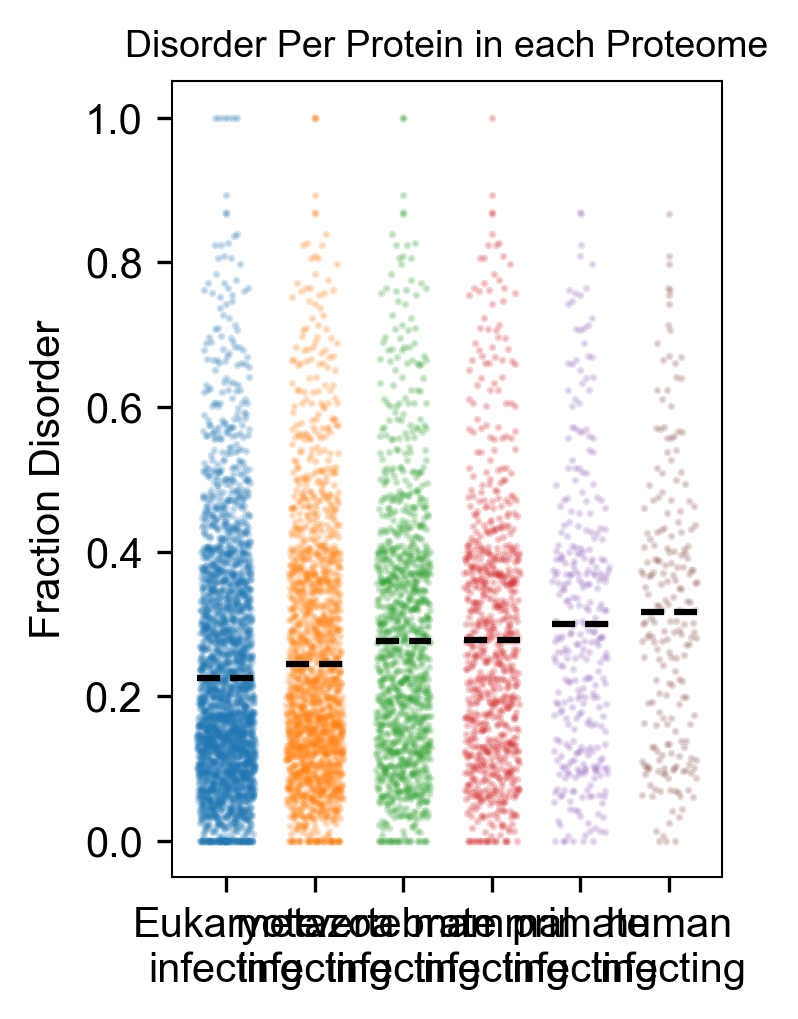

In [113]:

#proteomes={'Prokaryote\ninfecting':prokaryote_infecting, 'E. coli\ninfecting': ecoli_infecting, 'Eukaryote\ninfecting': eukaryotic_infecting, 'H. sapiens\ninfecting':human_infecting, 'metazoa\ninfecting':metazoa_infecting}
proteomes={'Eukaryote\ninfecting': eukaryotic_infecting, 'metazoa\ninfecting':metazoa_infecting, 'vertebrate\ninfecting':vertebrate_infecting, 'mammal\ninfecting':mammal_infecting, 'primate\ninfecting':primate_infecting, 'human\ninfecting':human_infecting}
#fig, [per_prot, total]=plt.subplots(ncols=2, nrows=1, figsize=(6.5, 3.5), dpi=150, facecolor='w', edgecolor='k')
fig, per_prot=plt.subplots(ncols=1, nrows=1, figsize=(2.5, 3.5), dpi=150, facecolor='w', edgecolor='k')
for n, p in enumerate(proteomes): 
    #plot per protein
    data=jitter_based_on_density(proteomes[p]['per_protein'], min_val=n, max_val=n, grouping_by=0.05)
    #per_prot.scatter(data[1], data[0], edgecolor='black', linewidth=0.3, alpha=0.1)
    per_prot.scatter(data[1], data[0], marker='.', s=3, alpha=0.2)
    avg=np.mean(data[0])
    per_prot.plot([min(data[1]), max(data[1])], [avg,avg], color='black', linestyle='dashed')
    per_prot.set_title('Disorder Per Protein in each Proteome', fontsize=9)
    # plot total
    #data=jitter_based_on_density(proteomes[p]['total_proteome'], min_val=n, max_val=n, grouping_by=0.02)
    #total.scatter(data[1], data[0], edgecolor='black', linewidth=0.3, alpha=0.1)
    #avg=np.mean(data[0])
    #total.plot([min(data[1]), max(data[1])], [avg,avg], color='black', linestyle='dashed')
    #total.set_title('Total Disorder in each Proteome', fontsize=9)

per_prot.set_xticks([a for a in range(0, len(proteomes.keys()))], list(proteomes.keys()))
total.set_xticks([a for a in range(0, len(proteomes.keys()))], list(proteomes.keys()))
plt.tight_layout()
per_prot.set_ylabel('Fraction Disorder')
#plt.savefig('Figure_4.pdf')

0
1


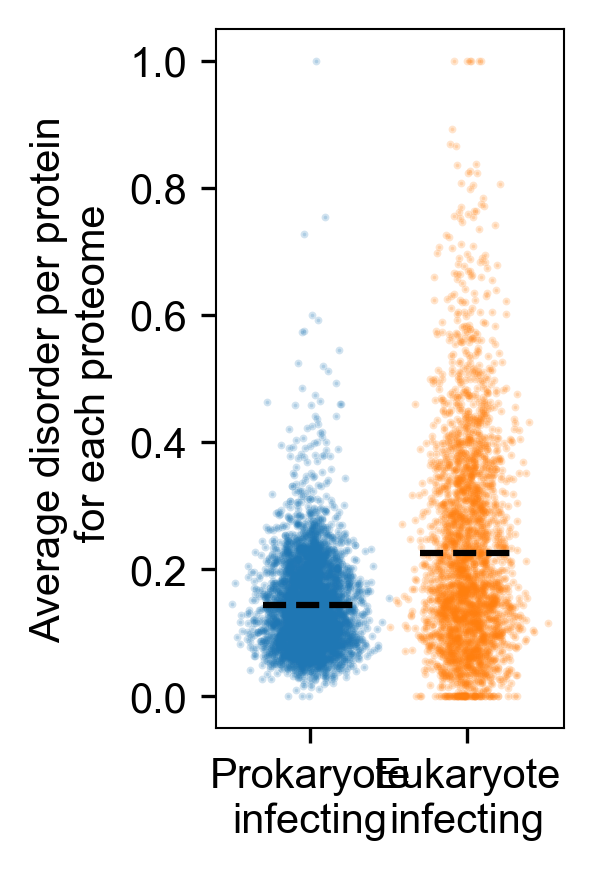

In [149]:

proteomes={'Prokaryote\ninfecting':prokaryote_infecting, 'Eukaryote\ninfecting': eukaryotic_infecting}
fig, per_prot=plt.subplots(ncols=1, nrows=1, figsize=(1.75, 3), dpi=150, facecolor='w', edgecolor='k')
for n, p in enumerate(proteomes): 
    #plot per protein
    #data=jitter_based_on_density(proteomes[p]['per_protein'], min_val=n, max_val=n, grouping_by=1)
    print(n)
    x_values, y_values=generate_density_based_scatter_data(proteomes[p]['per_protein'], center=n, base_width=0.1, scale_factor=0.05)#, base_w=0.4)
    per_prot.scatter(x_values, y_values, marker='.', s=3, alpha=0.2)
    avg=np.mean(y_values)
    per_prot.plot([n-0.3, n+0.3], [avg,avg], color='black', linestyle='dashed')
    # plot total
    #data=jitter_based_on_density(proteomes[p]['total_proteome'], min_val=n, max_val=n, grouping_by=0.02)
    #total.scatter(data[1], data[0], edgecolor='black', linewidth=0.3, alpha=0.1)
    #avg=np.mean(data[0])
    #total.plot([min(data[1]), max(data[1])], [avg,avg], color='black', linestyle='dashed')
    #total.set_title('Total Disorder in each Proteome', fontsize=9)

per_prot.set_xticks([a for a in range(0, len(proteomes.keys()))], list(proteomes.keys()))
total.set_xticks([a for a in range(0, len(proteomes.keys()))], list(proteomes.keys()), fontsize=8)
plt.tight_layout()
per_prot.set_ylabel('Average disorder per protein\n for each proteome')
plt.savefig('prokaryote_vs_eukaryote_infecting_viruses.pdf')